In [55]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
df = pd.read_parquet('../data/processed.parquet')

In [56]:
feature_cols = ['circuit','fp1_time', 'fp2_time', 'fp3_time', 'quali_time', 'fp2_minus_fp1', 'fp3_minus_fp2'] 
X = df[feature_cols]
y = df['podium_finish']

X = pd.get_dummies(X, columns=['circuit'])

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBClassifier(n_estimators=100, random_state=42, scale_pos_weight=5)
model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [58]:
y_pred = model.predict(X_test)

y_pred_proba = model.predict_proba(X_test) 


thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]

print("=== THRESHOLD ANALYSIS ===")
for threshold in thresholds:
    y_pred_threshold = (y_pred_proba[:, 1] >= threshold).astype(int)
    print(f"\n--- Threshold: {threshold} ---")
    print(classification_report(y_test, y_pred))

    positive_predictions = sum(y_pred)
    print(f"Number of podium predictions: {positive_predictions}")

print("\n=== DEFAULT THRESHOLD (0.5) ===")
y_pred_default = (y_pred_proba[:, 1] >= 0.5).astype(int) 
print(classification_report(y_test, y_pred_default))

positive_predictions = sum(y_pred)
print(f"Number of podium predictions: {positive_predictions}")

=== THRESHOLD ANALYSIS ===

--- Threshold: 0.1 ---
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       372
           1       0.33      0.29      0.31        62

    accuracy                           0.82       434
   macro avg       0.61      0.60      0.60       434
weighted avg       0.81      0.82      0.81       434

Number of podium predictions: 54

--- Threshold: 0.2 ---
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       372
           1       0.33      0.29      0.31        62

    accuracy                           0.82       434
   macro avg       0.61      0.60      0.60       434
weighted avg       0.81      0.82      0.81       434

Number of podium predictions: 54

--- Threshold: 0.3 ---
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       372
           1       0.33      0.29      0.31        62

    accuracy     

In [59]:
print("=== PROBABILITY ANALYSIS ===")

podium_probs = y_pred_proba[:, 1][y_test == 1]
non_podium_probs = y_pred_proba[:, 1][y_test == 0]

print(f"Average probability for actual podium finishers: {podium_probs.mean():.3f}")
print(f"Average probability for non-podium finishers: {non_podium_probs.mean():.3f}")
print(f"Max probability for podium finisher: {podium_probs.max():.3f}")
print(f"Min probability for podium finisher: {podium_probs.min():.3f}")


high_prob_indices = np.where(y_pred_proba[:, 1] > 0.3)[0]
print(f"\nDrivers with >30% podium probability: {len(high_prob_indices)}")

=== PROBABILITY ANALYSIS ===
Average probability for actual podium finishers: 0.350
Average probability for non-podium finishers: 0.158
Max probability for podium finisher: 0.962
Min probability for podium finisher: 0.005

Drivers with >30% podium probability: 100


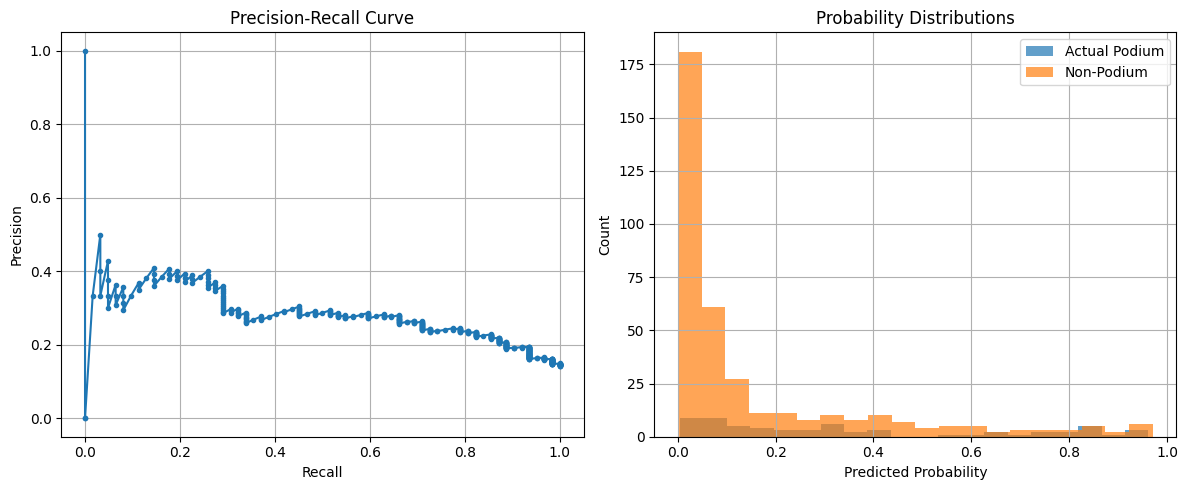

In [60]:
# Plot precision-recall curve
precision, recall, thresholds_curve = precision_recall_curve(y_test, y_pred_proba[:, 1])

plt.figure(figsize=(12, 5))

# Plot 1: Precision-Recall Curve
plt.subplot(1, 2, 1)
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)

# Plot 2: Probability distributions
plt.subplot(1, 2, 2)
plt.hist(podium_probs, alpha=0.7, label='Actual Podium', bins=20)
plt.hist(non_podium_probs, alpha=0.7, label='Non-Podium', bins=20)
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.title('Probability Distributions')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()